In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [22]:
df = pd.read_csv('OnlineRetail.csv',encoding="ISO-8859-1")
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [24]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [25]:
df = df.dropna()

In [26]:
df['Amount'] = df['Quantity']*df['UnitPrice']
monetary = df.groupby('CustomerID')['Amount'].sum()
monetary = monetary.reset_index()
monetary.tail()

,CustomerID,Amount
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88
4371,18287.0,1837.28


In [27]:
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
# rfm_f.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [15]:
# df['CustomerID'] = df['CustomerID'].astype(str)


In [32]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')

df['Diff'] = max(df['InvoiceDate']) - df['InvoiceDate']
recency = df.groupby('CustomerID')['Diff'].min()

# recency['Diff'] = recency['Diff'].dt.days
recency = recency.reset_index()
recency.head()


,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [31]:
recency

CustomerID
12346.0   325 days 02:33:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
                 ...       
18280.0   277 days 02:58:00
18281.0   180 days 01:57:00
18282.0     7 days 01:07:00
18283.0     3 days 00:48:00
18287.0    42 days 03:21:00
Name: Diff, Length: 4372, dtype: timedelta64[ns]

In [33]:
recency['Diff'] = recency['Diff'].dt.days
recency.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [34]:
rfm = pd.merge(recency, frequency, on='CustomerID', how='inner')

In [35]:
rfm = pd.merge(rfm, monetary, on='CustomerID', how='inner')

In [46]:
rfm.columns = ['CustomerID', 'Recency','Frequency','Monetary']


In [47]:
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,182,4310.00
2,12348.0,74,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,309,17,334.40
...,...,...,...,...
4367,18280.0,277,10,180.60
4368,18281.0,180,7,80.82
4369,18282.0,7,13,176.60
4370,18283.0,3,756,2094.88


Text(0.5, 0, 'Attributes')

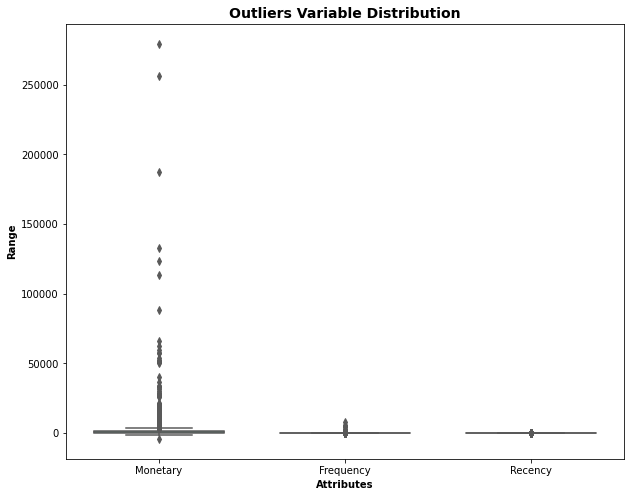

In [48]:
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [67]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Monetary.quantile(0.05)
Q3 = rfm.Monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [68]:
scaler = StandardScaler()
rfm_normalized = rfm[['Monetary','Frequency','Recency']]
rfm_normalized

,Monetary,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309
...,...,...,...
4366,173.90,9,73
4367,180.60,10,277
4368,80.82,7,180
4369,176.60,13,7


In [69]:
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized

,0,1,2
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188
...,...,...,...
4288,-0.624669,-0.683068,-0.193560
4289,-0.620853,-0.673094,1.826341
4290,-0.677696,-0.703017,0.865898
4291,-0.623131,-0.643171,-0.847057


In [70]:
rfm_normalized.columns = ['Monetary','Frequency','Recency']

Text(0.5, 0, 'Attributes')

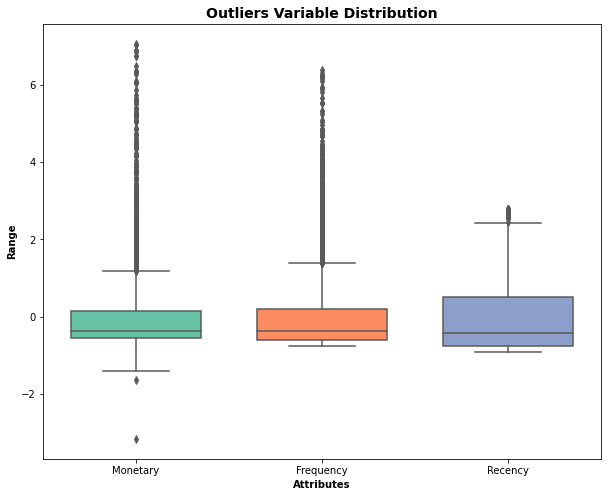

In [71]:
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_normalized[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [72]:
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_normalized)

KMeans(max_iter=50, n_clusters=4)

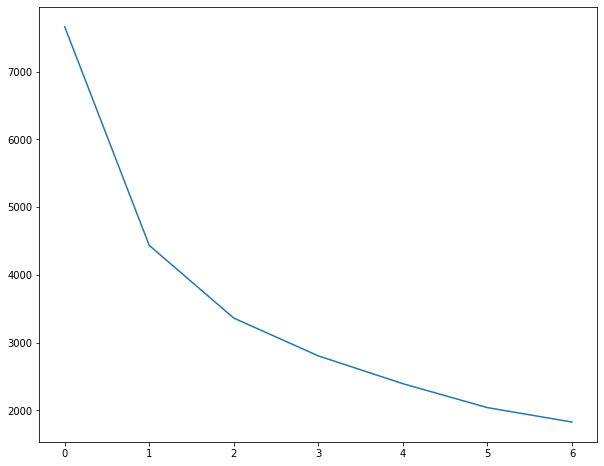

In [73]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

In [74]:

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_normalized)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.541842117113117
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48087228802439813
For n_clusters=5, the silhouette score is 0.4662700564189704
For n_clusters=6, the silhouette score is 0.4169897163641209
For n_clusters=7, the silhouette score is 0.4149577013665841
For n_clusters=8, the silhouette score is 0.41204738950102465


In [75]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_normalized)

KMeans(max_iter=50, n_clusters=3)

In [77]:
rfm_normalized.loc[:,'CustomerID'] = rfm['CustomerID']

In [78]:
rfm_normalized

,Monetary,Frequency,Recency,CustomerID
0,-0.723738,-0.752888,2.301611,12346.0
1,1.731617,1.042467,-0.906466,12347.0
2,0.300128,-0.463636,-0.183658,12348.0
3,0.277517,-0.044720,-0.738141,12349.0
4,-0.533235,-0.603275,2.143188,12350.0
...,...,...,...,...
4288,-0.624669,-0.683068,-0.193560,18176.0
4289,-0.620853,-0.673094,1.826341,18177.0
4290,-0.677696,-0.703017,0.865898,18178.0
4291,-0.623131,-0.643171,-0.847057,18179.0


In [79]:
rfm_normalized['cluster'] = kmeans.labels_
rfm_normalized

,Monetary,Frequency,Recency,CustomerID,cluster
0,-0.723738,-0.752888,2.301611,12346.0,0
1,1.731617,1.042467,-0.906466,12347.0,2
2,0.300128,-0.463636,-0.183658,12348.0,1
3,0.277517,-0.044720,-0.738141,12349.0,1
4,-0.533235,-0.603275,2.143188,12350.0,0
...,...,...,...,...,...
4288,-0.624669,-0.683068,-0.193560,18176.0,1
4289,-0.620853,-0.673094,1.826341,18177.0,0
4290,-0.677696,-0.703017,0.865898,18178.0,0
4291,-0.623131,-0.643171,-0.847057,18179.0,1


<AxesSubplot:xlabel='cluster', ylabel='Monetary'>

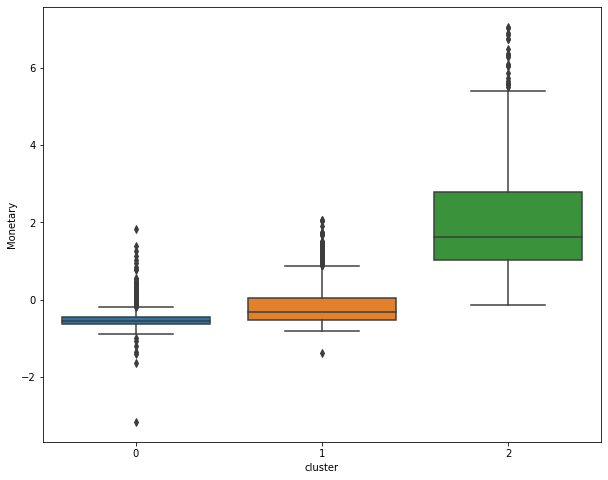

In [81]:
sns.boxplot(x='cluster', y='Monetary', data=rfm_normalized)

<AxesSubplot:xlabel='cluster', ylabel='Frequency'>

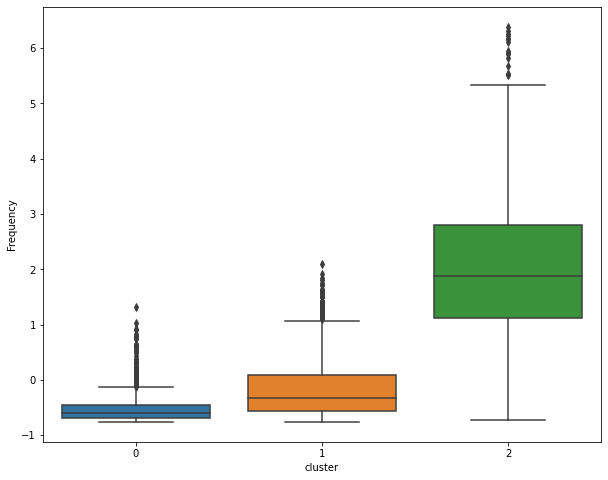

In [82]:
sns.boxplot(x='cluster', y='Frequency', data=rfm_normalized)

<AxesSubplot:xlabel='cluster', ylabel='Recency'>

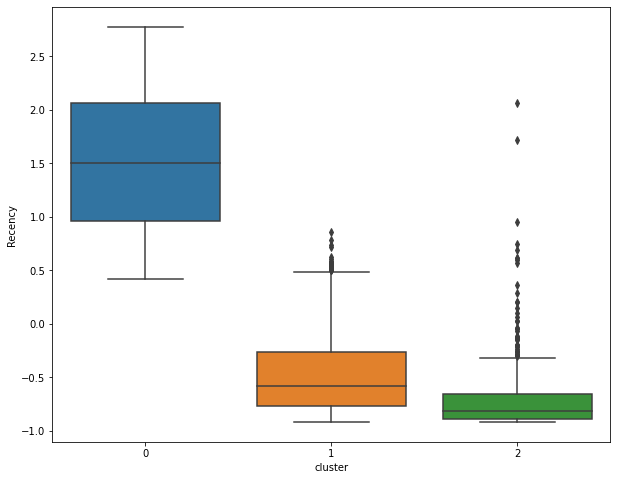

In [83]:
sns.boxplot(x='cluster', y='Recency', data=rfm_normalized)

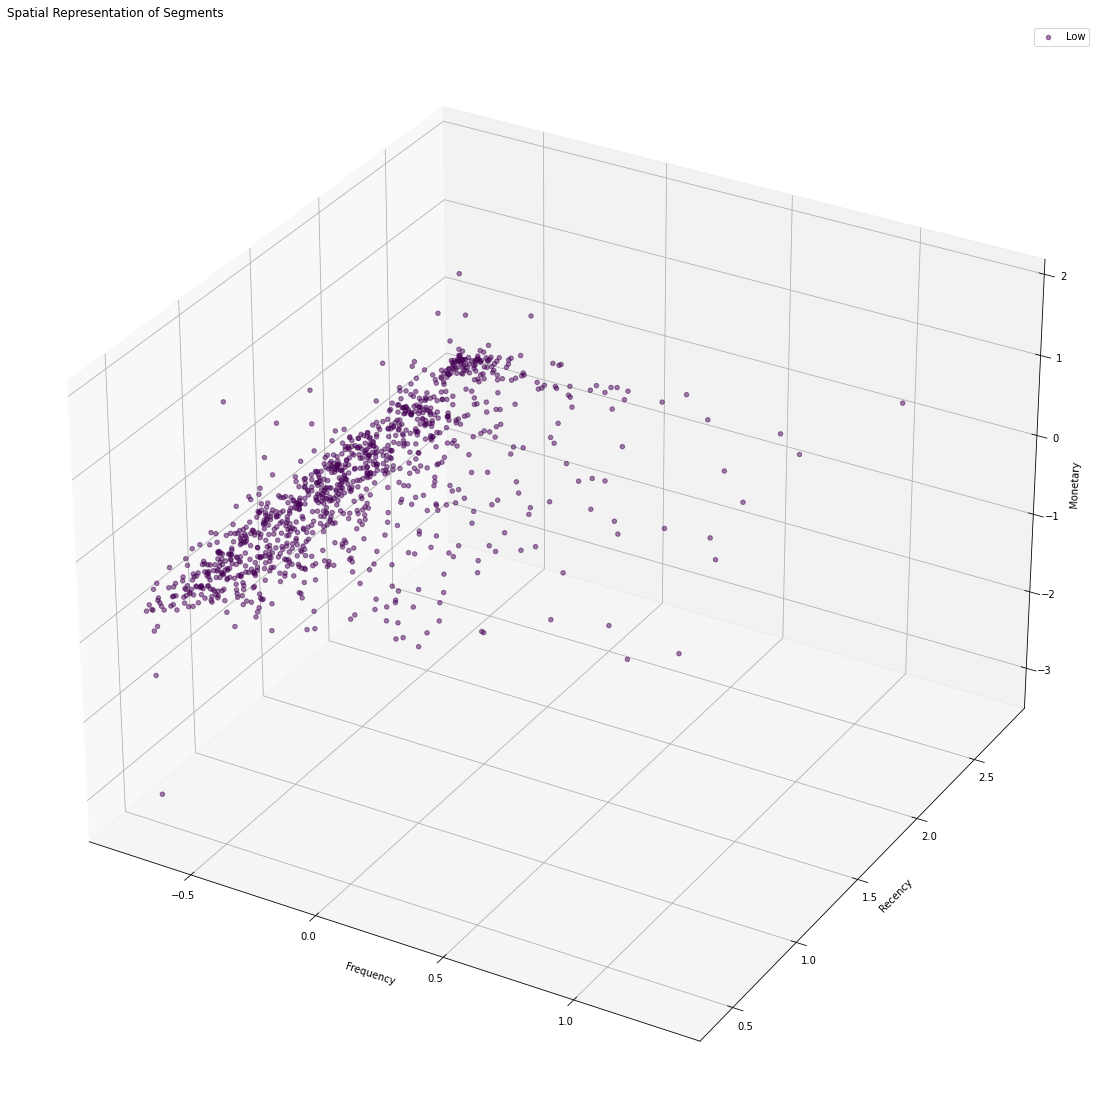

In [101]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

high = rfm_normalized.query('cluster == 2')
mid = rfm_normalized.query('cluster == 1')
low = rfm_normalized.query('cluster == 0')

from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook
# %matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

g1= (low['Frequency'].values, low['Recency'].values, low['Monetary'].values)
g2 = (mid['Frequency'].values, mid['Recency'].values, mid['Monetary'].values)
g3= (high['Frequency'].values, high['Recency'].values, high['Monetary'].values)

data = [g1, g2, g3]
colors = ['#440154FF', '#20A387FF', '#FDE725FF']
groups = ['Low', 'Med', 'High']

for data, color, group in zip(data, colors, groups):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.5, c=color, label=group)

# Make legend
    ax.legend()
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Recency')
    ax.set_zlabel('Monetary')
    ax.set_title('Spatial Representation of Segments', loc='left')
    plt.show();

In [97]:
rfm_normalized.query('cluster == 2')

,Monetary,Frequency,Recency,CustomerID,cluster
1,1.731617,1.042467,-0.906466,12347.0,2
10,2.812697,0.533783,-0.599520,12357.0,2
12,2.834266,1.760608,-0.847057,12359.0,2
15,2.212764,1.960092,-0.896564,12362.0,2
20,1.296199,0.892854,-0.421293,12370.0,2
...,...,...,...,...,...
4246,2.873973,2.209447,-0.906466,18119.0,2
4248,2.330371,2.079782,-0.896564,18121.0,2
4249,2.234139,1.670841,-0.540111,18122.0,2
4252,3.421825,0.862931,-0.807451,18126.0,2


Text(0.5, 1.0, 'Clustering: Frequency vs Recency')

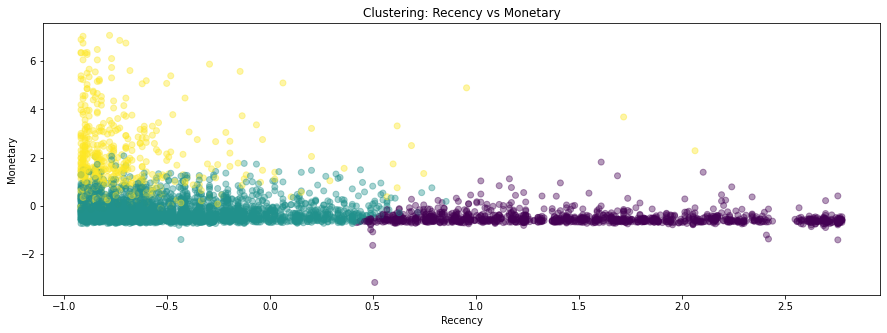

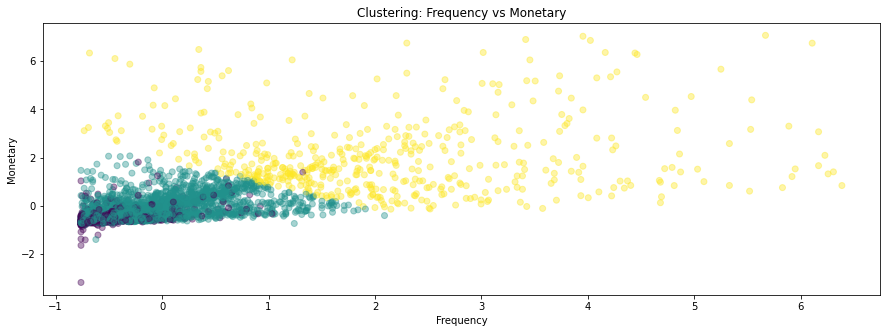

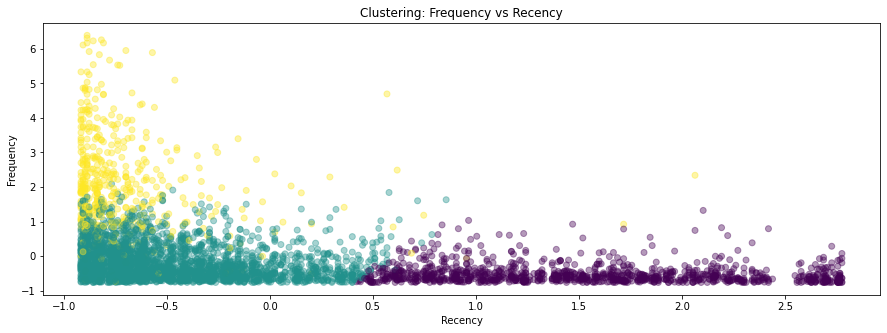

In [129]:
plt.rcParams["figure.figsize"] = (15,5)

plt.subplots()
plt.scatter(x=rfm_normalized['Recency'], y=rfm_normalized['Monetary'], c=rfm_normalized['cluster'], alpha=0.4)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title("Clustering: Recency vs Monetary")

plt.subplots()
plt.scatter(x=rfm_normalized['Frequency'], y=rfm_normalized['Monetary'], c=rfm_normalized['cluster'], alpha=0.4)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title("Clustering: Frequency vs Monetary")

plt.subplots()
plt.scatter(x=rfm_normalized['Recency'], y=rfm_normalized['Frequency'], c=rfm_normalized['cluster'], alpha=0.4)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title("Clustering: Frequency vs Recency")

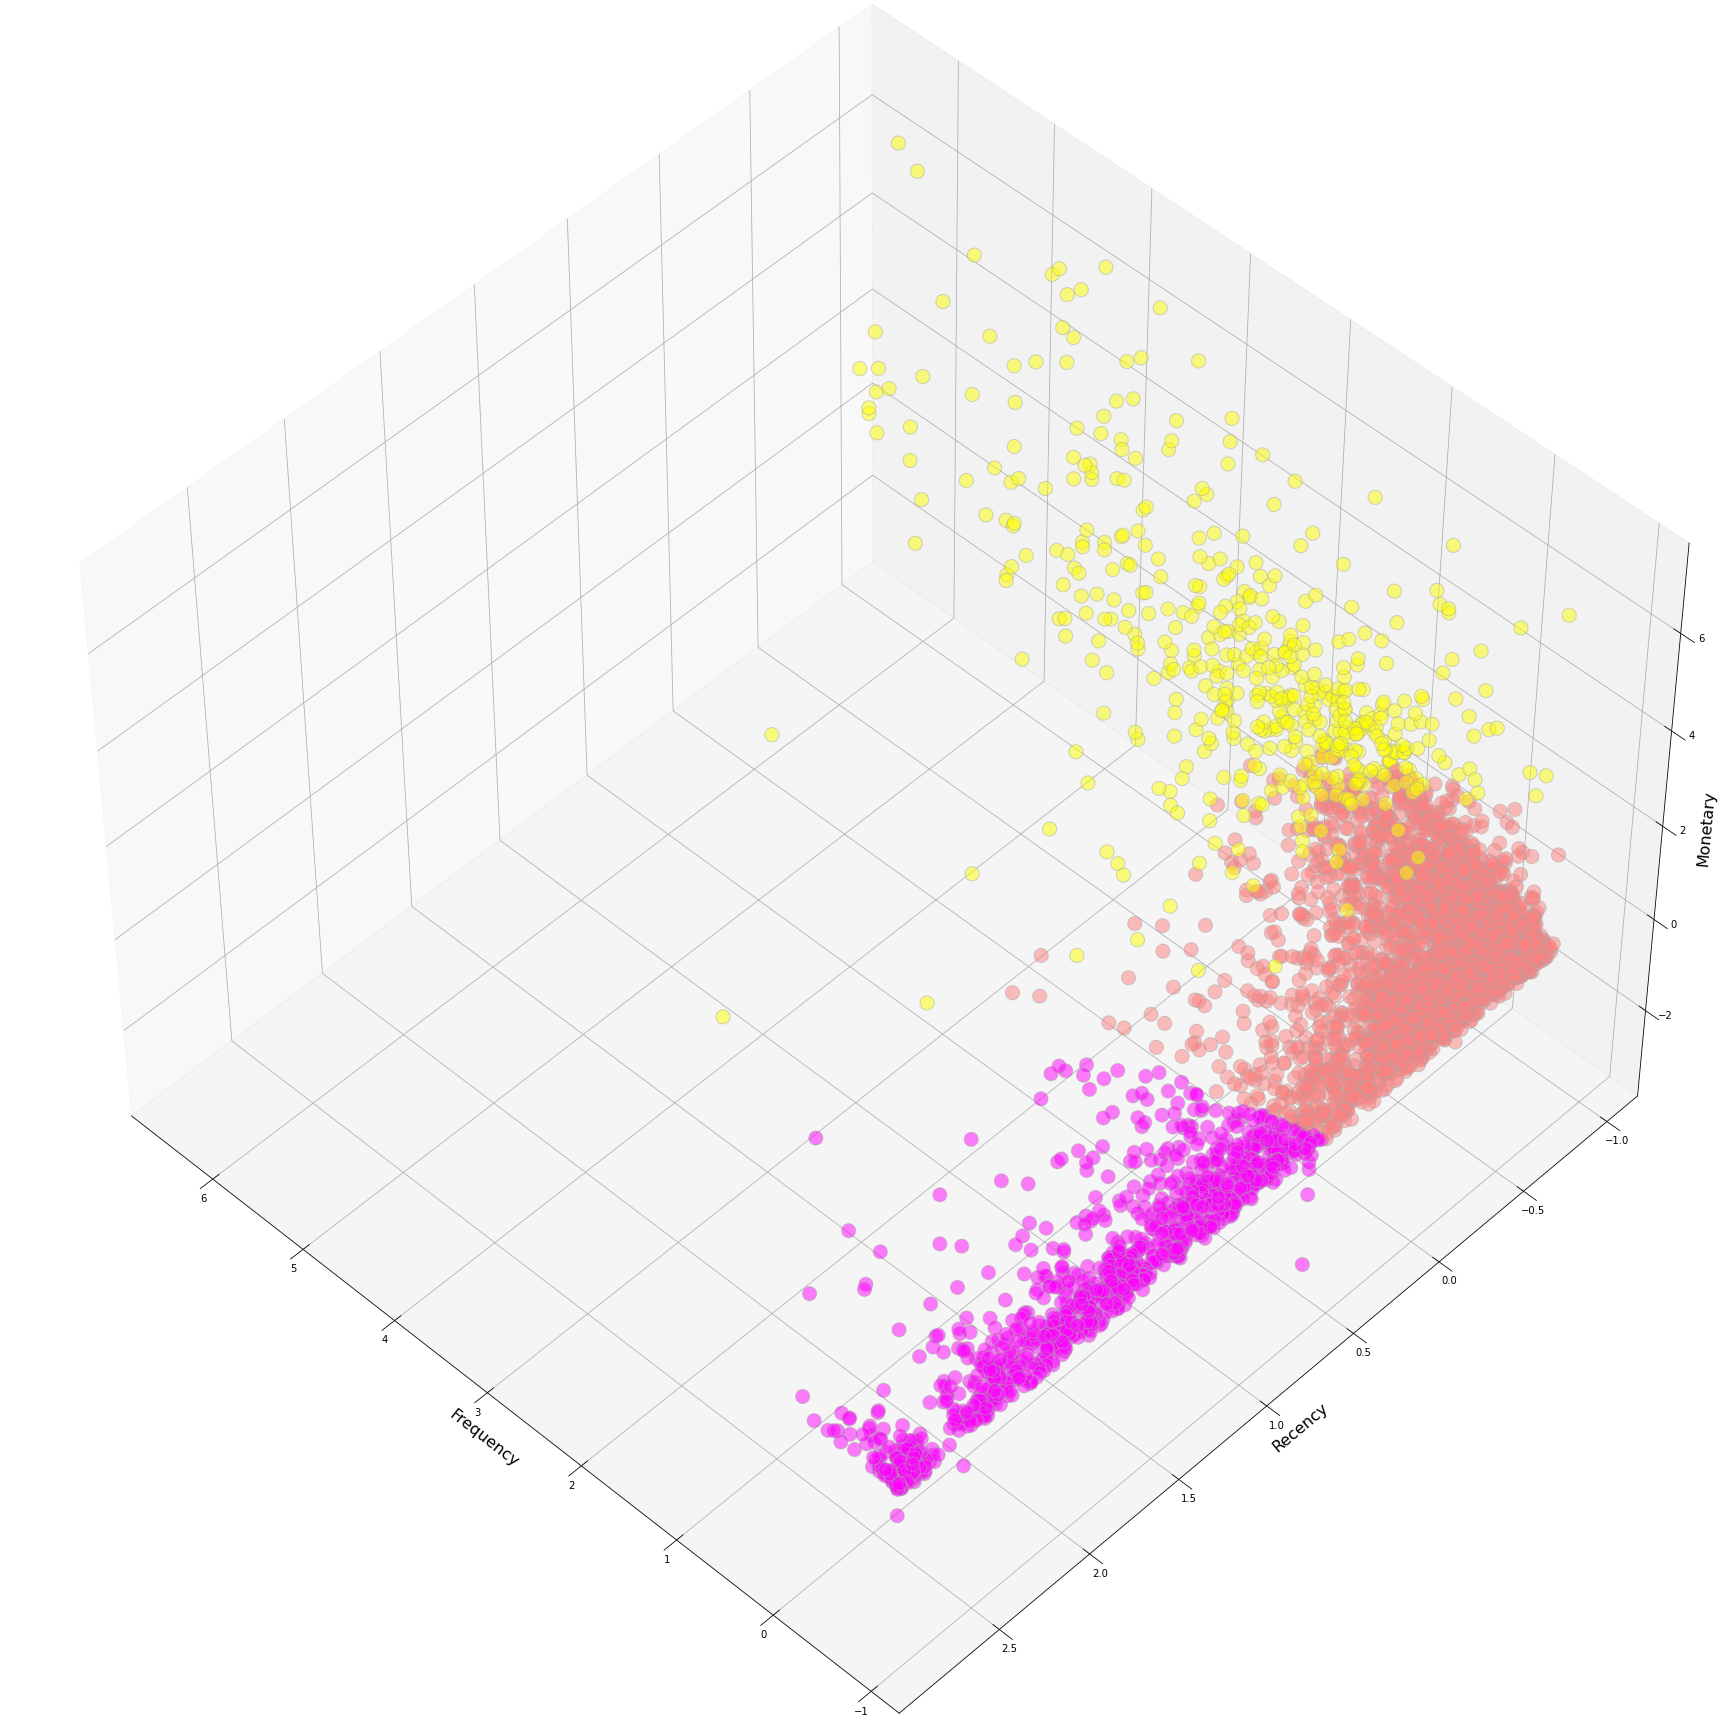

In [123]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,25)
fig = plt.figure(1)
plt.clf()
ax = Axes3D(fig, 
            rect = [0, 0, .95, 1], 
            elev = 48, 
            azim = 134)

plt.cla()
ax.scatter(rfm_normalized['Frequency'], rfm_normalized['Recency'],rfm_normalized['Monetary'],  
           c = rfm_normalized['cluster'], 
           s = 200, 
           cmap = 'spring', 
           alpha = 0.5, 
           edgecolor = 'darkgrey')

ax.set_xlabel('Frequency', 
              fontsize = 16)
ax.set_ylabel('Recency', 
              fontsize = 16)
ax.set_zlabel('Monetary', 
              fontsize = 16)

plt.show()